In the "Register Conformers" tutorial we generated conformers for a set of molecules and save the conformers, along with metadata about how they were generated in lwreg. Here we show how to use those conformers in a computational experiment.

In [1]:
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True
import lwreg
from lwreg import utils,standardization_lib
import rdkit
from rdkit.Chem import rdEHTTools


from rdkit import RDLogger
RDLogger.DisableLog('rdApp.info')

In [2]:
from datetime import datetime
def non_default_params_to_dict(obj,defaults):
    res = {}
    for k in dir(obj):
        if k.startswith('__'):
            continue
        v = getattr(obj,k)
        if callable(v):
            continue
        if v == getattr(defaults,k):
            continue
        else:
            res[k] = v
    return res

In [3]:
config = utils.defaultConfig()
config['dbtype'] = 'postgresql'
config['dbname'] = 'lwreg_conformer_tutorial'

# for each molecule we want to register one or more conformers
config['registerConformers'] = True

# For this application we're going to assume that the molecules which 
# come in are already standardized, so we won't make any changes to them
config['standardization'] = 'none'

In [4]:
utils.set_default_config(config)
cn = utils.connect(config)

# Register the experiment:

Here we will do a simple QM calculation (using extended Hueckel theory so that it goes fast) and store some of the calculated properties from those calculations in the database.

Start by registering some metadata about the experiment itself

In [5]:
qm_expt_metadata = {
    'Experiment Type':'QM single point',
    'Method': 'eHT',
    'RDKit Version': rdkit.__version__,
    'Date': str(datetime.now()),
    'note': 'property calculation with mulliken charges and reduced overlap populations'
}
import json
import uuid
qm_expt_uid = str(uuid.uuid4())
curs = cn.cursor()
curs.execute('insert into experiments.metadata values (%s,%s)',(str(qm_expt_uid),json.dumps(qm_expt_metadata)))
cn.commit()

# Run the experiment and store the results

We'll run all the conformers stored in the database:

In [6]:
# get all the molregnos
mrns = lwreg.get_all_registry_numbers()

# get all the (molregno,conf_id) pairs:
conf_tpls = lwreg.query(ids=mrns)

# retrieve the conformers themselves, this is a dictionary keyed by
# (molregno,conf_id) tuples. The values are (molblock,'mol') tuples
confs = lwreg.retrieve(ids=conf_tpls)


# loop over all the conformers, run the calculation, and save
# the computed results
for (mrn,conf_id) in confs:
    mb,_ = confs[(mrn,conf_id)]
    mol = Chem.MolFromMolBlock(mb,removeHs=False)

    # run the calculation:
    ok,res = rdEHTTools.RunMol(mol)
    if not ok:
        continue

    # fetch the values we're interested in and store them in a dictionary:
    d = {'atomic_charges':list(res.GetAtomicCharges())}
    opm = res.GetReducedOverlapPopulationMatrix()
    bnds = []
    nats = mol.GetNumAtoms()
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtomIdx()
        a2 = bond.GetEndAtomIdx()
        if a1<a2:
            a1,a2 = a2,a1
            
        o = opm[(a1*(a1+1))//2 + a2]
        bnds.append(o)
    d['mulliken_overlap_pops'] = bnds
    
    # write that result to the experiments table:
    with cn.cursor() as writeCurs:
        writeCurs.execute('insert into experiments.data values (%s,%s,%s)',(qm_expt_uid,conf_id,json.dumps(d)))
        cn.commit()



!!! Warning !!! Distance between atoms 51 and 22 (0.973851 A) is suspicious.
!!! Warning !!! Distance between atoms 52 and 23 (0.973267 A) is suspicious.
!!! Warning !!! Distance between atoms 51 and 22 (0.978365 A) is suspicious.
!!! Warning !!! Distance between atoms 52 and 23 (0.975536 A) is suspicious.
!!! Warning !!! Distance between atoms 51 and 22 (0.973878 A) is suspicious.
!!! Warning !!! Distance between atoms 52 and 23 (0.976998 A) is suspicious.
!!! Warning !!! Distance between atoms 51 and 22 (0.971844 A) is suspicious.
!!! Warning !!! Distance between atoms 52 and 23 (0.975992 A) is suspicious.
!!! Warning !!! Distance between atoms 51 and 22 (0.977795 A) is suspicious.
!!! Warning !!! Distance between atoms 52 and 23 (0.974047 A) is suspicious.
!!! Warning !!! Distance between atoms 62 and 25 (0.973985 A) is suspicious.
!!! Warning !!! Distance between atoms 63 and 26 (0.986391 A) is suspicious.
!!! Warning !!! Distance between atoms 62 and 25 (0.973622 A) is suspicious.

# Retrieving and working with the experiment data

In [7]:
cn = utils.connect(config)
curs = cn.cursor()


Get the most recent experiment of the appropriate type:


In [8]:
# it's cool that we can query with JSON directly:
expt_query = {'Experiment Type':'QM single point', 'Method':'eHT'}
curs.execute("select * from experiments.metadata where metadata@>%s order by metadata->>'Date' desc",
            (json.dumps(expt_query),))
expt_uid,md = curs.fetchone()
print(expt_uid)
print(md)


627026ae-b97f-4edf-b46c-8a6abe23a662
{'Date': '2025-02-25 10:29:50.865998', 'note': 'property calculation with mulliken charges and reduced overlap populations', 'Method': 'eHT', 'RDKit Version': '2024.09.5', 'Experiment Type': 'QM single point'}


Get the results for that experiment along with the corresponding conformers.

Here we are explicit about the expt_uid so that we get the same results even if we later add new experiments to the database.

In [15]:
expt_uid = '627026ae-b97f-4edf-b46c-8a6abe23a662'
curs.execute(f'select conf_id,data,molblock from experiments.data join {utils.conformersTableName} using (conf_id) \
    where expt_uid=%s',(expt_uid,))
rows = curs.fetchall()
len(rows)

49

Now do something with the results.

We'll plot the mulliken overlap population vs bond distance for all the C-C bonds in the data set and color the points by the bond type.

In [16]:
cc_mops = []
cc_dists = []
cc_bos = []
for cid,qmd,molb in rows:
    mops = qmd['mulliken_overlap_pops']
    mol = Chem.MolFromMolBlock(molb,removeHs=False)
    assert mol is not None
    conf = mol.GetConformer()
    for idx,mop in enumerate(mops):
        bnd = mol.GetBondWithIdx(idx)
        if bnd.GetBeginAtom().GetAtomicNum()==6 and bnd.GetEndAtom().GetAtomicNum()==6:
            dist = (conf.GetAtomPosition(bnd.GetBeginAtomIdx())-conf.GetAtomPosition(bnd.GetEndAtomIdx())).Length()
            cc_mops.append(mop)
            cc_dists.append(dist)
            cc_bos.append(bnd.GetBondType())

In [17]:
from collections import defaultdict
cc_dists_1 = defaultdict(list)
cc_mops_1 = defaultdict(list)
for bo,d,mop in zip(cc_bos,cc_dists,cc_mops):
    cc_dists_1[bo].append(d)
    cc_mops_1[bo].append(mop)

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

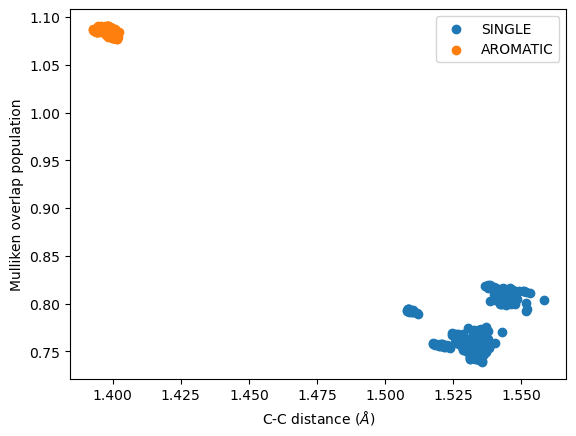

In [19]:
for k in cc_dists_1.keys():
    plt.scatter(cc_dists_1[k],cc_mops_1[k],label=str(k))
plt.legend()
plt.xlabel(r'C-C distance ($\AA$)')
plt.ylabel('Mulliken overlap population');